# **<font size=4 color=#BB3D00 face=微软雅黑>信号平滑处理</font>**

## **<font size=3  face=微软雅黑>※Matlab案例</font>** 

网址：https://ww2.mathworks.cn/help/signal/ug/signal-smoothing.html   
描述：本案例由4个示例构成。   
### - <font color=DarkOrChid size=3>示例1：如何使用移动平均滤波器和重采样来隔离一天中时间的周期性分量对每小时温度读数的影响</font>
### - <font color=DarkOrChid size=3>示例2：如何从开环电压测量中去除不需要的线路噪声</font>
### - <font color=DarkOrChid size=3>示例3：如何使用中值滤波器来平滑时钟信号的电平，同时保留边缘</font>
### - <font color=DarkOrChid size=3>示例4：如何使用 Hampel 滤波器去除较大的异常值</font>

## **<font size=3 face=微软雅黑>※Python案例</font>**

针对以上案例，采用Python语言实现。

### - <font color  =DarkOrChid size=3>示例1：如何使用移动平均滤波器和重采样来隔离一天中时间的周期性分量对每小时温度读数的影响</font>

#### **<font color=#BB3D00 size=3>目的</font>**

平滑可以在数据中发现关键特征同时忽略不重要噪声。可以使用滤波来实现平滑。平滑的目标是产生缓慢的值变化以便更容易看到数据的趋势。在下面的示例中，数据来源于2011年1月整个月份中每小时在洛根机场采样的温度。

In [1]:
!wget https://github.com/spaitlab/pyspt/blob/2f44d9082a26696e7c4d5b717861ae5d2ed5101d/2-%E4%BF%A1%E5%8F%B7%E7%94%9F%E6%88%90%E5%92%8C%E9%A2%84%E5%A4%84%E7%90%86/2-1-%E5%B9%B3%E6%BB%91%E5%92%8C%E5%8E%BB%E5%99%AA/2-1-1-%E4%BF%A1%E5%8F%B7%E5%B9%B3%E6%BB%91%E5%A4%84%E7%90%86/bostemp.mat?raw=true

'wget' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [ ]:
!ls

In [ ]:
!mv bostemp.mat\?raw\=true bostemp.mat

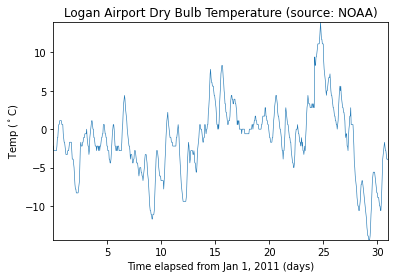

In [2]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

tempC = loadmat("bostemp.mat")
days = (np.arange(31*24)+1)/24
fig,ax = plt.subplots();ax.plot(days,tempC['tempC'],linewidth=0.6)
ax.set_title('Logan Airport Dry Bulb Temperature (source: NOAA)')
ax.set_xlabel('Time elapsed from Jan 1, 2011 (days)')
ax.set_ylabel('Temp ($ ^\circ $C)')
ax.autoscale(tight=True)

我们可以直观地看到一天中的时间对温度读数的影响。如果只关注一个月内的每日温度变化，则每小时的波动只会产生噪声，使得每日的变化很难辨别。为了去除时间的影响，我们接下来使用移动平均滤波器来平滑处理数据。

#### **<font color=#BB3D00 size=3 >移动平均滤波器</font>**

长度为N的移动平均滤波器的最简单形式是取波形的每$N$个连续采样的平均值。为了对每个数据点应用移动平均滤波器，构造滤波器的系数使得每个点的权重相等且占比为总均值的$1/24$。这样可以得出每24小时的平均温度。

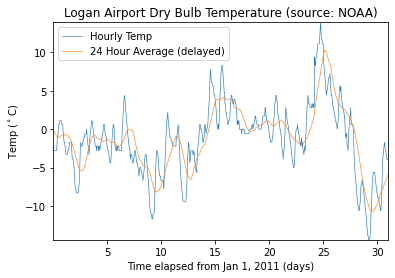

In [19]:
from scipy import signal
hoursPerDay = 24
coeff24hMA = np.ones(hoursPerDay)/hoursPerDay
zi = signal.lfilter_zi(coeff24hMA,1)*0
avg24hTempC,_ = signal.lfilter(coeff24hMA,1,tempC['tempC'].flatten(),zi=zi)
fig,ax = plt.subplots()
ax.plot(days,tempC['tempC'],linewidth=0.6,label='Hourly Temp')
ax.plot(days,avg24hTempC,linewidth=0.6,label='24 Hour Average (delayed)')
ax.legend()
ax.set_title('Logan Airport Dry Bulb Temperature (source: NOAA)')
ax.set_xlabel('Time elapsed from Jan 1, 2011 (days)')
ax.set_ylabel('Temp ($ ^\circ $C)')
ax.autoscale(tight=True)

#### **<font color=#BB3D00 size=3>滤波器延迟</font>**

因为移动平均滤波器有延迟，滤波后的输出存在大约12个小时的延迟。长度为$N$的任何对称滤波器都存在$(N-1)/2$个采样的延迟。可以人为去除这种延迟。

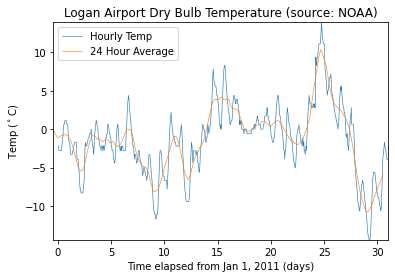

In [20]:
fDelay = (coeff24hMA.size-1)/2;
fig,ax = plt.subplots()
ax.plot(days,tempC['tempC'],linewidth=0.6,label='Hourly Temp')
ax.plot(days-fDelay/24,avg24hTempC,linewidth=0.6,label='24 Hour Average')
ax.legend()
ax.set_title('Logan Airport Dry Bulb Temperature (source: NOAA)')
ax.set_xlabel('Time elapsed from Jan 1, 2011 (days)')
ax.set_ylabel('Temp ($ ^\circ $C)')
ax.autoscale(tight=True)

#### **<font color=#BB3D00 size=3>提取平均差值</font>**

也可以使用移动平均滤波器来更好地估计一天中的时间如何影响整体温度。为此，首先从每小时的温度测量值中减去平滑处理后的数据。然后，将差值数据按天数分段连接，取一月中所有31天的平均值。

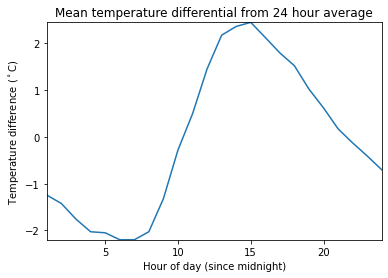

In [21]:
deltaTempC = tempC['tempC'].flatten() - avg24hTempC;
fig,ax = plt.subplots()
ax.plot(np.arange(24)+1,np.mean(deltaTempC.reshape(31,24),0))
ax.set_title('Mean temperature differential from 24 hour average')
ax.set_xlabel('Hour of day (since midnight)')
ax.set_ylabel('Temperature difference ($ ^\circ $C)')
ax.autoscale(tight=True)

#### **<font color=#BB3D00 size=3>提取峰值包络</font>**

温度信号的高低每天都有变化，有时也希望对这种变化有平滑变化估计。为此，可以使用**signal.find_peaks**函数来连接在24小时内的某个时段检测到的极高值和极低值。在此示例中，确保在每个极高值和极低值之间有至少16个小时。还可以通过取两个极端点之间的平均值来了解高点和低点的趋势。

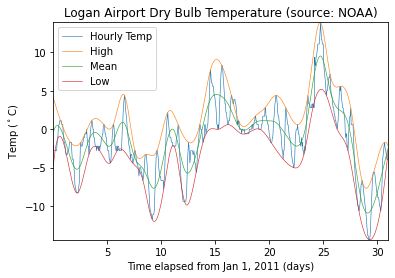

In [22]:
from scipy import interpolate
envHigh_index,_ = signal.find_peaks(tempC['tempC'].flatten(),distance=16)
envHigh = (interpolate.UnivariateSpline(days[envHigh_index],
         tempC['tempC'][envHigh_index].flatten(),s=0))
envLow_index,_ = signal.find_peaks(-tempC['tempC'].flatten(),distance=16)
envLow = (interpolate.UnivariateSpline(days[envLow_index],
         tempC['tempC'][envLow_index].flatten(),s=0))
envMean = (envHigh(days)+envLow(days))/2;
fig,ax = plt.subplots()
ax.plot(days,tempC['tempC'],linewidth=0.6,label='Hourly Temp')
ax.plot(days,envHigh(days),linewidth=0.6,label='High')
ax.plot(days,envMean,linewidth=0.6,label='Mean')
ax.plot(days,envLow(days),linewidth=0.6,label='Low')
ax.legend()
ax.set_title('Logan Airport Dry Bulb Temperature (source: NOAA)')
ax.set_xlabel('Time elapsed from Jan 1, 2011 (days)')
ax.set_ylabel('Temp ($ ^\circ $C)')
ax.autoscale(tight=True)

#### **<font color=#BB3D00 size=3>加权移动平均滤波器</font>**

其他类型的移动平均滤波器并不对每个采样进行同等加权。另一种常见滤波器遵循$[1/2,1/2]^n$的二项式展开。对于大的$n$值，这种类型的滤波器逼近正态曲线。对于小的$n$值，这种滤波器适合滤除高频噪声。要找到二项式滤波器的系数，请对$[1/2,1/2]$进行自身卷积，然后用$[1/2,1/2]$与输出以迭代方式进行指定次数的卷积。在此示例中，总共使用五次迭代。

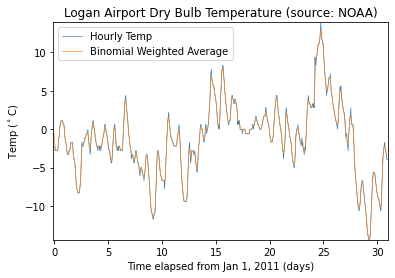

In [23]:
h = np.array([1/2,1/2])
binomialCoeff = signal.convolve(h,h)
for n in range(4):
    binomialCoeff = signal.convolve(binomialCoeff,h)
fDelay = (len(binomialCoeff)-1)/2
zi = signal.lfilter_zi(binomialCoeff,1)*0
binomialMA,_ = signal.lfilter(binomialCoeff,1,tempC['tempC'].flatten(),zi=zi)
fig,ax = plt.subplots()
ax.plot(days,tempC['tempC'],linewidth=0.6,label='Hourly Temp')
ax.plot(days-fDelay/24,binomialMA,linewidth=0.6,label='Binomial Weighted Average')
ax.legend()
ax.set_title('Logan Airport Dry Bulb Temperature (source: NOAA)')
ax.set_xlabel('Time elapsed from Jan 1, 2011 (days)')
ax.set_ylabel('Temp ($ ^\circ $C)')
ax.autoscale(tight=True)

另一种有点类似高斯展开滤波器的滤波器是指数移动平均滤波器。这种类型的加权移动平均滤波器易于构造，并且不需要大的窗大小。可以通过介于0和1之间的$\alpha$参数来调整指数加权移动平均滤波器。$\alpha$值越高，平滑度越低。

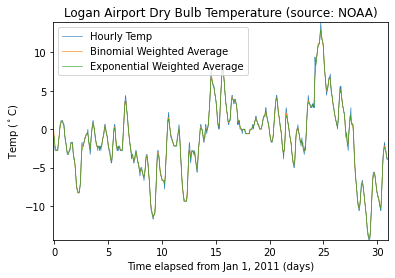

In [24]:
alpha = 0.45
zi = signal.lfilter_zi(np.array([alpha]),np.array([1,alpha-1]))*0
exponentialMA,_ = (signal.lfilter(np.array([alpha]),np.array([1,alpha-1]),
                   tempC['tempC'].flatten(),zi=zi))
fig,ax = plt.subplots()
ax.plot(days,tempC['tempC'],linewidth=0.6,label='Hourly Temp')
ax.plot(days-fDelay/24,binomialMA,linewidth=0.6,label='Binomial Weighted Average')
ax.plot(days-1/24,exponentialMA,linewidth=0.6,label='Exponential Weighted Average')
ax.legend()
ax.set_title('Logan Airport Dry Bulb Temperature (source: NOAA)')
ax.set_xlabel('Time elapsed from Jan 1, 2011 (days)')
ax.set_ylabel('Temp ($ ^\circ $C)')
ax.autoscale(tight=True)

放大一天的读数。

(-5.0, 2.0)

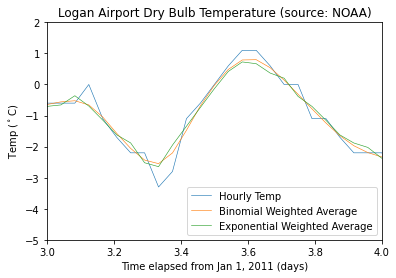

In [25]:
fig,ax = plt.subplots()
ax.plot(days,tempC['tempC'],linewidth=0.6,label='Hourly Temp')
ax.plot(days-fDelay/24,binomialMA,linewidth=0.6,label='Binomial Weighted Average')
ax.plot(days-1/24,exponentialMA,linewidth=0.6,label='Exponential Weighted Average')
ax.legend()
ax.set_title('Logan Airport Dry Bulb Temperature (source: NOAA)')
ax.set_xlabel('Time elapsed from Jan 1, 2011 (days)')
ax.set_ylabel('Temp ($ ^\circ $C)')
ax.set_xlim([3,4])
ax.set_ylim([-5,2])

#### **<font color=#BB3D00 size=3 >Savitzky-Golay 滤波器</font>**

可以看到通过平滑处理数据，极值得到一定程度的削减。为了更紧密地跟踪信号，可以使用加权移动平均滤波器，该滤波器尝试以最小二乘方式对指定数量的采样进行指定阶数的多项式拟合。为了方便起见，可以使用函数**signal.savgol_filter**来实现**Savitzky-Golay**平滑滤波器。要使用**signal.savgol_filter**，请指定一个奇数长度段的数据和严格小于该段长度的多项式阶。**signal.savgol_filter**函数在内部计算平滑多项式系数，执行延迟对齐，并处理数据记录开始和结束位置的瞬变效应。

(-5.0, 2.0)

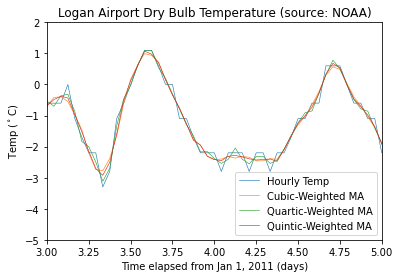

In [26]:
cubicMA = signal.savgol_filter(tempC['tempC'].flatten(),7,3)
quarticMA = signal.savgol_filter(tempC['tempC'].flatten(),7,4)
quinticMA = signal.savgol_filter(tempC['tempC'].flatten(),9,5)
fig,ax = plt.subplots()
ax.plot(days,tempC['tempC'],linewidth=0.6,label='Hourly Temp')
ax.plot(days,cubicMA,linewidth=0.6,label='Cubic-Weighted MA')
ax.plot(days,quarticMA,linewidth=0.6,label='Quartic-Weighted MA')
ax.plot(days,quinticMA,linewidth=0.6,label='Quintic-Weighted MA')
ax.legend()
ax.set_title('Logan Airport Dry Bulb Temperature (source: NOAA)')
ax.set_xlabel('Time elapsed from Jan 1, 2011 (days)')
ax.set_ylabel('Temp ($ ^\circ $C)')
ax.autoscale(tight=True)
ax.set_xlim([3,5])
ax.set_ylim([-5,2])

### - <font color  =DarkOrChid size=3 >示例2：如何从开环电压测量中去除不需要的线路噪声</font>

#### **<font color=#BB3D00 size=3>重采样</font>**

有时为了正确应用移动平均值，需要对信号进行重采样。在本示例中某模拟仪器输入端其存在$60 Hz$交流电源线噪声的干扰，我们以$1 kHz$采样率对开环电压进行采样。

In [1]:
!wget https://github.com/spaitlab/pyspt/blob/2f44d9082a26696e7c4d5b717861ae5d2ed5101d/2-%E4%BF%A1%E5%8F%B7%E7%94%9F%E6%88%90%E5%92%8C%E9%A2%84%E5%A4%84%E7%90%86/2-1-%E5%B9%B3%E6%BB%91%E5%92%8C%E5%8E%BB%E5%99%AA/2-1-1-%E4%BF%A1%E5%8F%B7%E5%B9%B3%E6%BB%91%E5%A4%84%E7%90%86/openloop60hertz.mat?raw=true

'wget' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [2]:
!ls

'ls' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [3]:
!mv openloop60hertz.mat\?raw\=true openloop60hertz.mat

'mv' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


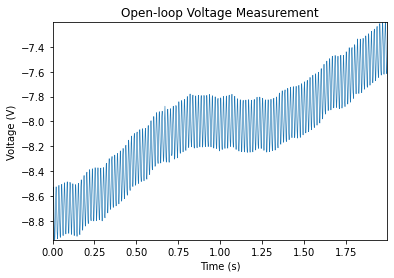

In [27]:
openLoopVoltage = loadmat("openloop60hertz.mat")
fs = 1000
t = np.arange(openLoopVoltage['openLoopVoltage'].size)/fs
fig,ax = plt.subplots()
ax.plot(t,openLoopVoltage['openLoopVoltage'],linewidth=0.6)
ax.set_ylabel('Voltage (V)')
ax.set_xlabel('Time (s)')
ax.set_title('Open-loop Voltage Measurement')
ax.autoscale(tight=True)

现在我们尝试通过使用移动平均滤波器来去除交流电噪声干扰的影响。


如果构造一个均匀加权的移动平均滤波器，它将去除相对于滤波器持续时间而言具有周期性的任何分量。以$1000 Hz$采样时，在$60 Hz$的完整周期内，大约有$1000/60=16.667$个采样。尝试“向上舍入”并使用一个 17 点滤波器。这将在$1000 Hz/17=58.82Hz$的基频下为我们提供最大滤波效果。

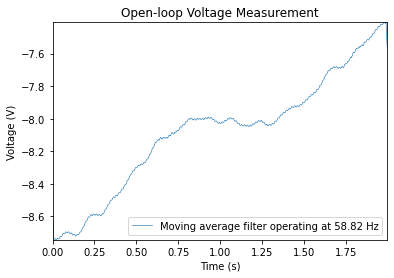

In [28]:
fig,ax = plt.subplots()
ax.plot(t,signal.savgol_filter(openLoopVoltage['openLoopVoltage'].flatten(),17,1),
        linewidth=0.6,label='Moving average filter operating at 58.82 Hz')
ax.set_ylabel('Voltage (V)')
ax.set_xlabel('Time (s)')
ax.set_title('Open-loop Voltage Measurement')
ax.legend(loc='lower right')
ax.autoscale(tight=True)

请注意，虽然电压明显经过平滑处理，但它仍然包含小的$60 Hz$波纹。如果对信号进行重采样，以便通过移动平均滤波器捕获$60Hz$信号的完整周期，就可以显著减弱该波纹。如果以$17*60Hz=1020Hz$对信号进行重采样，可以使用17点移动平均滤波器来去除$60 Hz$的电线噪声。

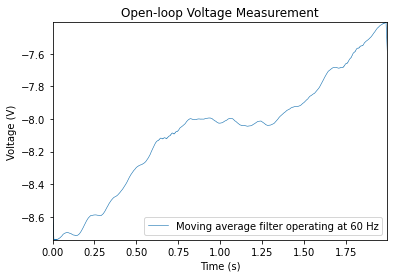

In [29]:
fsResamp = 1020
vResamp = signal.resample(openLoopVoltage['openLoopVoltage'].flatten(),
                          int(openLoopVoltage['openLoopVoltage'].size/fs*fsResamp))
tResamp = np.arange(vResamp.size)/fsResamp
vAvgResamp = signal.savgol_filter(vResamp,17,1)
fig,ax = plt.subplots()
ax.plot(tResamp,vAvgResamp,linewidth=0.6,label='Moving average filter operating at 60 Hz')
ax.set_ylabel('Voltage (V)')
ax.set_xlabel('Time (s)')
ax.set_title('Open-loop Voltage Measurement')
ax.legend(loc='lower right')
ax.autoscale(tight=True)

### - <font color  =DarkOrChid size=3>示例3：如何使用中值滤波器来平滑时钟信号的电平，同时保留边缘</font>

#### **<font color=#BB3D00 size=3>中值滤波器</font>**

移动平均滤波器、加权移动平均滤波器和**Savitzky-Golay**滤波器对它们滤波的所有数据进行平滑处理。然而，有时我们并不需要这种处理。例如，如果数据取自时钟信号并且不希望对其中的锐边进行平滑处理，该怎么办？到当前为止讨论的滤波器都不太适用。

In [ ]:
!wget https://github.com/spaitlab/pyspt/blob/5822c454c397d30771f51362d00978960515b804/2-%E4%BF%A1%E5%8F%B7%E7%94%9F%E6%88%90%E5%92%8C%E9%A2%84%E5%A4%84%E7%90%86/2-1-%E5%B9%B3%E6%BB%91%E5%92%8C%E5%8E%BB%E5%99%AA/2-1-1-%E4%BF%A1%E5%8F%B7%E5%B9%B3%E6%BB%91%E5%A4%84%E7%90%86/clockex.mat?raw=true

In [ ]:
!ls

In [ ]:
!mv clockex.mat\?raw\=true clockex.mat

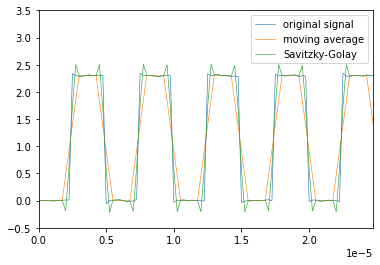

In [30]:
clock = loadmat('clockex.mat')
yMovingAverage = signal.convolve(clock['x'].flatten(),np.ones(5)/5,mode='same')
ySavitzkyGolay = signal.savgol_filter(clock['x'].flatten(),5,3)
fig,ax = plt.subplots()
ax.plot(clock['t'],clock['x'],linewidth=0.6,label='original signal')
ax.plot(clock['t'],yMovingAverage,linewidth=0.6,label='moving average')
ax.plot(clock['t'],ySavitzkyGolay,linewidth=0.6,label='Savitzky-Golay')
ax.set_ylim([-0.5,3.5])
ax.legend(loc='upper right')
ax.autoscale(enable=True, axis='x', tight=True)

移动平均滤波器和**Savitzky-Golay**滤波器分别在时钟信号的边沿附近进行欠校正和过校正。保留边沿但仍平滑处理水平的一种简单方法是使用中值滤波器。

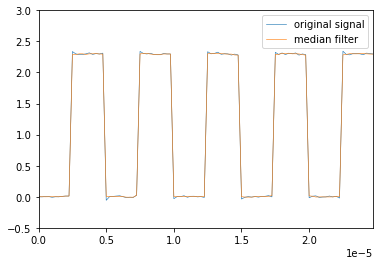

In [31]:
yMedFilt = signal.medfilt(clock['x'].flatten(),5)
fig,ax = plt.subplots()
ax.plot(clock['t'],clock['x'],linewidth=0.6,label='original signal')
ax.plot(clock['t'],yMedFilt,linewidth=0.6,label='median filter')
ax.set_ylim([-0.5,3])
ax.legend(loc='upper right')
ax.autoscale(enable=True, axis='x', tight=True)

### - <font color  =DarkOrChid size=3>示例4：如何使用Hample滤波器去除较大的异常值</font>

#### **<font color=#BB3D00 size=3>使用 Hampel 滤波器去除离群值</font>**

许多滤波器对离群值很敏感。与中值滤波器密切相关的一种滤波器是**Hampel**滤波器。此滤波器有助于在不过度平滑处理数据的情况下去除信号中的离群值。为了演示这一点，加载一段火车鸣笛的录音，并添加一些人为噪声尖峰。

In [ ]:
!wget https://github.com/spaitlab/pyspt/blob/2f44d9082a26696e7c4d5b717861ae5d2ed5101d/2-%E4%BF%A1%E5%8F%B7%E7%94%9F%E6%88%90%E5%92%8C%E9%A2%84%E5%A4%84%E7%90%86/2-1-%E5%B9%B3%E6%BB%91%E5%92%8C%E5%8E%BB%E5%99%AA/2-1-1-%E4%BF%A1%E5%8F%B7%E5%B9%B3%E6%BB%91%E5%A4%84%E7%90%86/train.mat?raw=true

In [ ]:
!ls

In [ ]:
!mv train.mat\?raw\=true train.mat

(0.0, 14000.0)

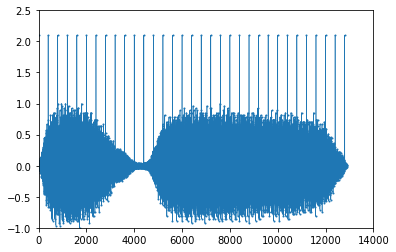

In [32]:
y = loadmat('train.mat')
y_addnoise = y['y'].flatten()
y_addnoise[::400] = 2.1
fig,ax = plt.subplots()
ax.scatter(np.arange(12880)+1,y_addnoise,s=1)
ax.plot(y_addnoise,linewidth=0.6,label='original signal')
ax.set_ylim([-1,2.5])
ax.set_xlim([0,14000])

由于引入的每个尖峰只有一个采样的持续时间，可以使用只包含三个元素的中值滤波器来去除尖峰。

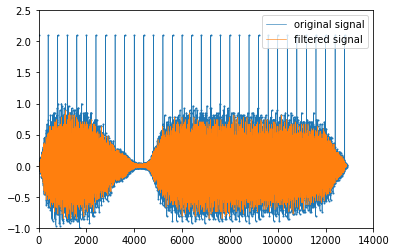

In [33]:
fig,ax = plt.subplots()
ax.scatter(np.arange(12880)+1,y_addnoise,s=1)
ax.plot(y_addnoise,linewidth=0.6,label='original signal')
ax.set_ylim([-1,2.5])
ax.set_xlim([0,14000])
ax.plot(signal.medfilt(y_addnoise,3),linewidth=0.6,label='filtered signal')
ax.legend()

该滤波器去除了尖峰，但同时去除了原始信号的大量数据点。**Hampel**滤波器的工作原理类似于中值滤波器，但它仅替换与局部中位数值相差几倍标准差的值。

In [ ]:
!pip install hampel

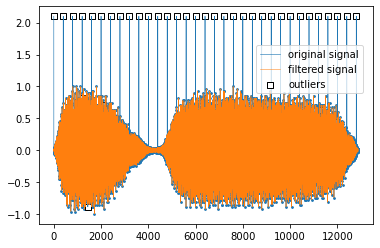

In [34]:
from hampel import hampel
import pandas as pd
y_an_series = pd.Series(y_addnoise.tolist())
y_addnoise_imp = hampel(y_an_series,window_size=11,imputation=True)
y_addnoise_out = hampel(y_an_series, window_size=11)
fig,ax = plt.subplots()
ax.plot(y_addnoise,linewidth=0.6,label='original signal')
ax.scatter(np.arange(12880)+1,y_addnoise,s=3)
ax.plot(y_addnoise_imp,linewidth=0.5,label='filtered signal')
ax.scatter(y_addnoise_out,y_addnoise[np.array(y_addnoise_out)],c='w',marker='s',edgecolors='black',label='outliers')
ax.legend(loc=(0.65,0.6))

仅离群值从原始信号中去除了。